<a target="_blank" href="https://colab.research.google.com/github/neurorishika/FlyOptoStimAnalysis/blob/main/analysis/pulse-learning-analysis.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# 16FlYMaze : Analysis of preference of with different Optogenetic Pulse Structures ($\lambda$ = 625nm) for Gr64f/CsChrimson flies

**Data Source:** *16FlYMaze System, Turner Lab, HHMI Janelia Research Campus*

**Collected By:** *Kaitlyn Boone, Aparna Dev, PTR, HHMI Janelia Research Campus*

**Code Author:** *Rishika Mohanta*

### Library Imports

In [2]:
# import libraries
import numpy as np                      # for numerical operations
import pandas as pd                     # for data manipulation
import matplotlib.pyplot as plt         # for plotting
import seaborn as sns                   # for plotting
import scipy.optimize as opt            # for optimization
from joblib import Parallel, delayed    # for parallelization
from tqdm.notebook import tqdm          # for progress bar
import pickle                           # for saving and loading
import os                               # for file operations
import datetime                         # for datetime operations
import flyoptostim.rdp_client as rdp    # for connecting RDP security standards
from joblib import Parallel, delayed    # for parallelization
from tqdm.notebook import tqdm          # for progress bar

### Analysis Variables (Change if Needed)

In [3]:
data_path = '../data/pulStr_24-07-2023.ezip' # path to encrypted files
save_path = '../processed_data/pulStr_24-07-2023' # path to save processed data
quality_control = 'full' # whether to perform quality control (valid options: minimal, full, none)
last_date = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S") # get current date and time
n_jobs = 10 # number of jobs for parallelization
rerun_fitting = False # whether to rerun fitting
subset_exp_analysis = ['vs'] # which experiments to analyze (valid options: learning, vs)

### Decrypt and Load Data

In [4]:
# Unencrypt Data
rdp.unlock_and_unzip_file(data_path,key_dir='../key.key')

# Redefine data path
data_path = data_path[:-5]+'/'

# load data
choice_data = np.loadtxt(data_path + 'choices.csv', delimiter=',')
reward_data = np.loadtxt(data_path + 'rewards.csv', delimiter=',')

# turn into integers
choice_data = choice_data.astype(int)
reward_data = reward_data.astype(int)

if choice_data.shape != reward_data.shape:
    raise ValueError('Sizes do not match.')

N = choice_data.shape[0]    # number of flies

print("Data loaded successfully with N = {} flies and {} maximum trials".format(N, choice_data.shape[1]))

# metadata
metadata = pd.read_csv(data_path + 'metadata.csv')
metadata['Experiment Start Time'] = pd.to_datetime(metadata['Experiment Start Time'], format='%Y-%m-%d %H:%M:%S')
metadata['Starvation Time'] = pd.to_datetime(metadata['Starvation Time'], format='%Y-%m-%d %H:%M:%S')

Data loaded successfully with N = 179 flies and 150 maximum trials


/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_63492/2110328854.py:12: RuntimeWarning: invalid value encountered in cast
  choice_data = choice_data.astype(int)
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_63492/2110328854.py:13: RuntimeWarning: invalid value encountered in cast
  reward_data = reward_data.astype(int)


### Perform Quality Control

In [5]:
# QUALITY CONTROL
def exp_in_subset(exp):
    for subset in subset_exp_analysis:
        if subset in exp.lower():
            return True
    return False

if quality_control == 'minimal':
    qc = np.loadtxt(data_path + 'quality_control.csv', delimiter=',').astype(bool)
    qc = qc & metadata['Fly Experiment'].apply(exp_in_subset)
    choice_data = choice_data[qc]
    reward_data = reward_data[qc]
    metadata = metadata[qc]
    metadata.reset_index(drop=True, inplace=True)
if quality_control == 'full':
    qc = np.loadtxt(data_path + 'quality_control.csv', delimiter=',').astype(bool)
    qc = qc & metadata['Fly Experiment'].apply(exp_in_subset)
    metadata = metadata[qc]
    metadata = metadata[metadata['Experiment Start Time'] < last_date].groupby('Fly Experiment').head(10)
    choice_data = choice_data[metadata.index]
    reward_data = reward_data[metadata.index]
    metadata.reset_index(drop=True, inplace=True)

print("{}/{} ({}) flies passed quality control".format(choice_data.shape[0], N, "{:0.2f}".format(choice_data.shape[0]/N*100)))

N = choice_data.shape[0]    # number of flies

34/179 (18.99) flies passed quality control


In [6]:
metadata['Fly Experiment'].value_counts()

Fly Experiment
HighI_vs_HalfT.csv                  6
HighI_vs_Standard.csv               5
HighI_vs_HalfT_reciprocal.csv       4
HighI_vs_Standard_reciprocal.csv    3
LowI_vs_Standard_reciprocal.csv     3
HighI_vs_LowI_reciprocal.csv        3
LowI_vs_Standard.csv                3
LowI_vs_HalfT.csv                   3
LowI_vs_HalfT_reciprocal.csv        2
HighI_vs_LowI.csv                   2
Name: count, dtype: int64

### Plot the Cumulative Choices made by flies over trials

The Cumulative Choice Plot (Choice 1 vs Choice 2) is shown below for the different experiments. The Reward Rate is also shown in the same plot. The Reward Rate is calculated as the number of times the fly chose the rewarded arm divided by the total number of times the fly chose either arm. The Reward Rate is calculated for every 10 trials and is plotted at the end of the 10 trials. 

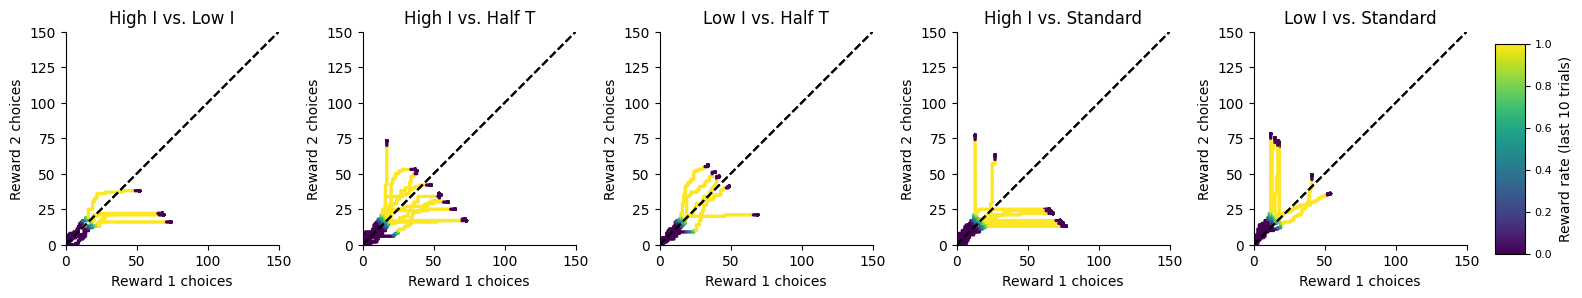

In [7]:
# PLOT CHOICES 

order_map = {
    'HighI_vs_LowI.csv':0, 
    'HighI_vs_LowI_reciprocal.csv':0,
    'HighI_vs_HalfT.csv':1, 
    'HighI_vs_HalfT_reciprocal.csv':1,
    'LowI_vs_HalfT.csv':2,
    'LowI_vs_HalfT_reciprocal.csv':2,
    'HighI_vs_Standard.csv':3,
    'HighI_vs_Standard_reciprocal.csv':3,
    'LowI_vs_Standard.csv':4,
    'LowI_vs_Standard_reciprocal.csv':4,
}
cmap = 'viridis'

fig, ax = plt.subplots(1,5, figsize=(15, 3))
for exp in metadata['Fly Experiment'].sort_values().unique():
    choice_set = choice_data[metadata[metadata['Fly Experiment'] == exp].index]
    reward_set = reward_data[metadata[metadata['Fly Experiment'] == exp].index]
    N_set = choice_set.shape[0]
    for i in range(N_set):
        reward_rate = np.convolve(reward_set[i,:], np.ones(10)/10, mode='same')
        if "_reciprocal" in exp:
            ax.flatten()[order_map[exp]].scatter(np.cumsum(choice_set[i,:]==1), np.cumsum(choice_set[i,:]==0), c=reward_rate, cmap=cmap, s=2, vmin=0, vmax=1)
        else:
            ax.flatten()[order_map[exp]].scatter(np.cumsum(choice_set[i,:]==0), np.cumsum(choice_set[i,:]==1), c=reward_rate, cmap=cmap, s=2, vmin=0, vmax=1)
    ax.flatten()[order_map[exp]].plot([0, choice_set.shape[1]], [0, choice_set.shape[1]], 'k--')
    ax.flatten()[order_map[exp]].set_xlabel('Reward 1 choices')
    ax.flatten()[order_map[exp]].set_ylabel('Reward 2 choices')
    ax.flatten()[order_map[exp]].set_xlim([0, choice_set.shape[1]])
    ax.flatten()[order_map[exp]].set_ylim([0, choice_set.shape[1]])
    ax.flatten()[order_map[exp]].set_title(exp[:-4].split('_reciprocal')[0].replace('_', ' ').replace('vs', 'vs.').replace('I',' I').replace('T',' T'))
    ax.flatten()[order_map[exp]].set_aspect('equal')
    ax.flatten()[order_map[exp]].spines['top'].set_visible(False)
    ax.flatten()[order_map[exp]].spines['right'].set_visible(False)

plt.tight_layout()

# add a colorbar to the entire figure
cbar_ax = fig.add_axes([1.0, 0.15, 0.02, 0.7])
cbar = fig.colorbar(ax.flatten()[1].collections[0], cax=cbar_ax, orientation='vertical')
cbar.set_label('Reward rate (last 10 trials)')
cbar.ax.tick_params(labelsize=8)

plt.show()

### Calculate Preference Index

In [76]:
pref_index_df = pd.DataFrame(columns=['Experiment', 'Preference index'])
for exp in metadata['Fly Experiment'].sort_values().unique():
    choice_set = choice_data[metadata[metadata['Fly Experiment'] == exp].index]
    reward_set = reward_data[metadata[metadata['Fly Experiment'] == exp].index]
    N_set = choice_set.shape[0]
    preference_index = np.zeros(N_set)
    for i in range(N_set):
        if "_reciprocal" in exp:
            preference_index[i] = (np.sum(choice_set[i,30:]==1) - np.sum(choice_set[i,30:]==0))/(np.sum(choice_set[i,30:]==1) + np.sum(choice_set[i,30:]==0))
        else:
            preference_index[i] = (np.sum(choice_set[i,30:]==0) - np.sum(choice_set[i,30:]==1))/(np.sum(choice_set[i,30:]==0) + np.sum(choice_set[i,30:]==1))
    exp_clean = exp[:-4].split('_reciprocal')[0].replace('_', ' ').replace('vs', 'vs.').replace('I',' I').replace('T',' T')
    pref_index_df = pd.concat([pref_index_df, pd.DataFrame({'Experiment': [exp_clean]*N_set, 'Preference index': preference_index, 'reciprocal': ["forward" if "_reciprocal" in exp else "reverse"]*N_set})], ignore_index=True)
pref_index_df.sort_values(by='Preference index', inplace=True)

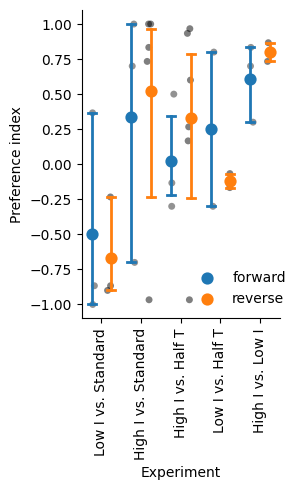

In [77]:
fig, ax = plt.subplots(1,1, figsize=(3, 5))
sns.stripplot(x='Experiment', y='Preference index', data=pref_index_df, ax=ax, hue='reciprocal', dodge=0.5, size=5, color='k', alpha=0.5, zorder=0)
sns.pointplot(x='Experiment', y='Preference index', data=pref_index_df, ax=ax, hue='reciprocal', dodge=0.5, join=False, ci=95, capsize=0.2, errwidth=2,zorder=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel('Preference index')
ax.set_ylim([-1.1, 1.1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
# hide legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[2:], labels[2:], loc='lower left', bbox_to_anchor=(0.5, 0.0), frameon=False)
plt.show()

